In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
nu = 0.25  # Poisson's ratio
r0 = 1.0   # Initial radius of the bone

# Function to generate synthetic data for axial strain over time
def generate_data(num_points=100):
    t = np.linspace(0, 10, num_points)  # time range
    epsilon_t = 0.1 * np.sin(t)  # Axial strain as a sine function of time (example)
    r_t = r0 * (1 - nu * epsilon_t)  # Radial deformation based on Poisson's ratio
    return t, epsilon_t, r_t

# Generate the dataset
t_train, epsilon_train, r_train = generate_data(num_points=100)



Epoch 0: Data Loss = 1001.930419921875, Physics Loss = 0.09852659702301025, Total Loss = 1002.0289306640625
Epoch 100: Data Loss = 7.0446600914001465, Physics Loss = 0.0009828266920521855, Total Loss = 7.045642852783203
Epoch 200: Data Loss = 1.141191840171814, Physics Loss = 0.0004059280327055603, Total Loss = 1.1415977478027344
Epoch 300: Data Loss = 0.5136386156082153, Physics Loss = 0.0003448127245064825, Total Loss = 0.513983428478241
Epoch 400: Data Loss = 0.29713404178619385, Physics Loss = 0.00032349975663237274, Total Loss = 0.2974575459957123
Epoch 500: Data Loss = 0.16843248903751373, Physics Loss = 0.0003107572556473315, Total Loss = 0.16874325275421143
Epoch 600: Data Loss = 0.09685440361499786, Physics Loss = 0.00030368418083526194, Total Loss = 0.09715808928012848
Epoch 700: Data Loss = 0.06001446023583412, Physics Loss = 0.0003000614233314991, Total Loss = 0.060314521193504333
Epoch 800: Data Loss = 0.04191645607352257, Physics Loss = 0.00029829941922798753, Total Loss 

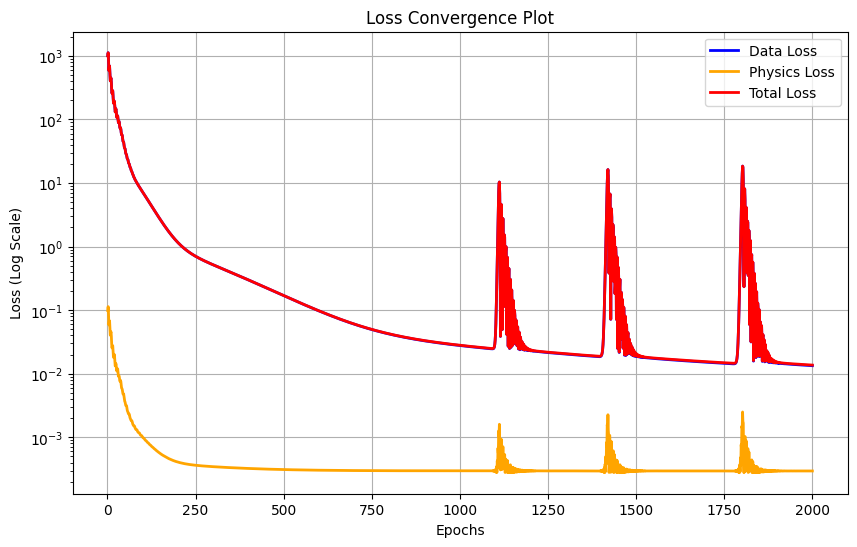

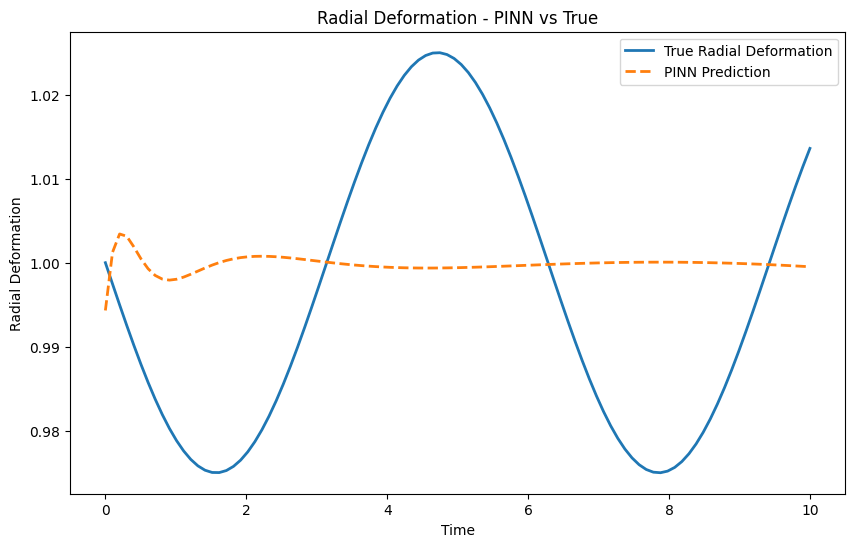

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# PINN Model definition
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(nodes, activation='tanh') for nodes in layers]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, t):
        x = tf.expand_dims(t, axis=-1)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Loss function for PINN with separate components
def compute_losses(model, t, epsilon_train, r_train):
    with tf.GradientTape() as tape:
        tape.watch(t)
        r_pred = model(t)
        epsilon_pred = - (r_pred - r0) / (r0 * nu)

    # Data loss (MSE between predicted and true epsilon)
    data_loss = tf.reduce_mean(tf.square(epsilon_pred - epsilon_train))
    # Physics loss (MSE between predicted and true r)
    physics_loss = tf.reduce_mean(tf.square(r_pred - r_train))
    # Total loss
    total_loss = data_loss + physics_loss

    return data_loss, physics_loss, total_loss

# Training function with logging
def train_pinn_with_logging(model, t_train, epsilon_train, r_train, epochs=1000, lr=0.0001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Initialize lists to log losses
    data_losses = []
    physics_losses = []
    total_losses = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Compute losses
            data_loss, physics_loss, total_loss = compute_losses(model, t_train, epsilon_train, r_train)

        # Log losses
        data_losses.append(data_loss.numpy())
        physics_losses.append(physics_loss.numpy())
        total_losses.append(total_loss.numpy())

        # Apply gradients
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Print loss values every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Data Loss = {data_loss.numpy()}, Physics Loss = {physics_loss.numpy()}, Total Loss = {total_loss.numpy()}")

    return data_losses, physics_losses, total_losses

# Function to plot loss convergence
def plot_loss_convergence(data_losses, physics_losses, total_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(data_losses) + 1)

    plt.plot(epochs, data_losses, label='Data Loss', color='blue', linewidth=2)
    plt.plot(epochs, physics_losses, label='Physics Loss', color='orange', linewidth=2)
    plt.plot(epochs, total_losses, label='Total Loss', color='red', linewidth=2)

    # Use log scale for y-axis
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Log Scale)')
    plt.title('Loss Convergence Plot')
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_convergence_plot.png", dpi=300)  # Save the plot as an image
    plt.show()

# Example training and plotting
# Define parameters
r0 = 1.0  # Example constant (adjust as needed)
nu = 0.01  # Example constant (adjust as needed)

# Create and train PINN model
layers = [32, 64, 64, 32]  # Architecture
pinn_model = PINN(layers)

# Convert training data to TensorFlow tensors (replace these with actual training data)
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
epsilon_train_tensor = tf.convert_to_tensor(epsilon_train, dtype=tf.float32)
r_train_tensor = tf.convert_to_tensor(r_train, dtype=tf.float32)

# Train the model with logging
data_losses, physics_losses, total_losses = train_pinn_with_logging(
    pinn_model, t_train_tensor, epsilon_train_tensor, r_train_tensor, epochs=2000, lr=0.001
)

# Plot loss convergence
plot_loss_convergence(data_losses, physics_losses, total_losses)

# Predictions using PINN
r_pinn_pred = pinn_model(t_train_tensor)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_train, r_train, label='True Radial Deformation', linewidth=2)
plt.plot(t_train, r_pinn_pred, '--', label='PINN Prediction', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Radial Deformation')
plt.legend()
plt.title('Radial Deformation - PINN vs True')
plt.savefig("radial_deformation_pinn.png", dpi=300)  # Save as PNG with high resolution
plt.show()


In [ ]:
# Save the plot as an image file
plt.savefig("radial_deformation_pinn.png", dpi=300)
plt.show()  # Save as PNG with high resolution


<Figure size 640x480 with 0 Axes>

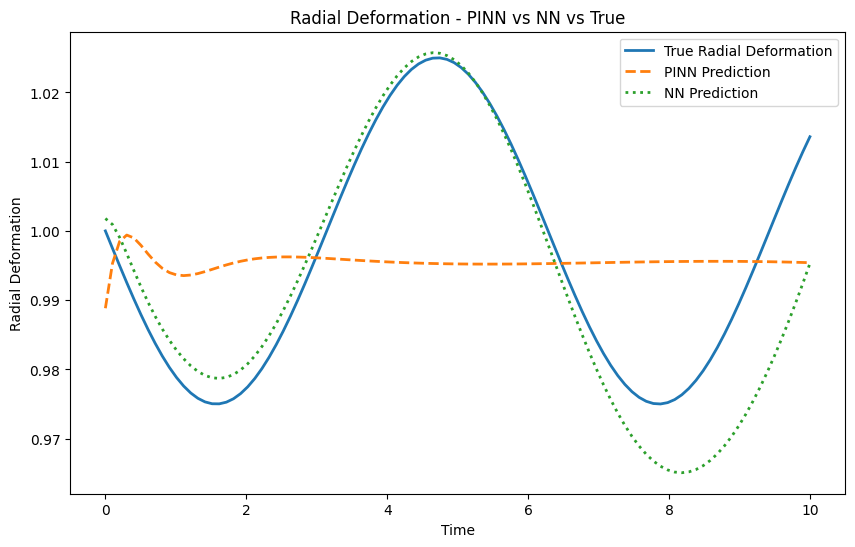

In [ ]:
# Traditional Neural Network for comparison
class NN(tf.keras.Model):
    def __init__(self, layers):
        super(NN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(nodes, activation='tanh') for nodes in layers]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, t):
        x = tf.expand_dims(t, axis=-1)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Train a traditional NN
nn_model = NN(layers)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the traditional NN model
nn_model.fit(t_train_tensor, r_train_tensor, epochs=2000, verbose=0)

# Predictions using NN
r_nn_pred = nn_model(t_train_tensor)

# Plot the comparison between PINN and NN
plt.figure(figsize=(10, 6))
plt.plot(t_train, r_train, label='True Radial Deformation', linewidth=2)
plt.plot(t_train, r_pinn_pred, '--', label='PINN Prediction', linewidth=2)
plt.plot(t_train, r_nn_pred, ':', label='NN Prediction', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Radial Deformation')
plt.legend()
plt.title('Radial Deformation - PINN vs NN vs True')
# Save the plot as an image file
plt.savefig("radial_deformation_pinn.png", dpi=300)  # Save as PNG with high resolution

plt.show()